# PyTorch y WaveNet


En este curso, nos inspiramos en la arquitectura del modelo [WaveNet](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/), propuesta por Google DeepMind para el procesamiento de audio. Nuestro objetivo es utilizar un mayor número de caracteres para el contexto de nuestro predictor de la siguiente palabra.


## Arquitectura


La arquitectura de WaveNet es una arquitectura jerárquica que otorga mayor peso a los elementos de contexto más cercanos.

A continuación, se muestra cómo es la arquitectura:

![WaveNet](./images/wavenet.png)

*Figura extraída del artículo original.*


## Implementación del modelo completamente conectado con PyTorch


El curso comienza con una adaptación de los conceptos del curso anterior, utilizando las funciones de PyTorch.


### Conjunto de datos


Retomemos el código del cuaderno anterior para la generación del conjunto de datos.


In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import TensorDataset, DataLoader, random_split

%matplotlib inline

In [39]:
# Lecture du dataset
words = open('prenoms.txt', 'r').read().splitlines()
print(words[:8])

['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ', 'JEANNE', 'PHILIPPE', 'LOUIS']


In [40]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Para variar, aumentemos el contexto de 3 a 8. Esto nos dará un indicador de rendimiento, ya que también usaremos 8 para nuestro modelo WaveNet.


In [41]:
block_size = 8 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] 
X = torch.tensor(X)
Y = torch.tensor(Y)

In [42]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Creación del modelo y entrenamiento


Para empezar, reimplementaremos el modelo del cuaderno anterior, pero utilizando PyTorch.


In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class fcn(nn.Module):
  def __init__(self,embed_dim=10,context_len=8,hidden_dim=300, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.embed_dim=embed_dim
    self.context_len=context_len
    
    #La fonction nn.Embedding de pytorch est l'équivalent de la matrice C 
    self.embedding=nn.Embedding(46,embed_dim)
    self.layer1=nn.Linear(embed_dim*context_len,hidden_dim)
    self.layer2=nn.Linear(hidden_dim,46)

  def forward(self,x):       
    embed=self.embedding(x) # Remplace la matrice C
    embed=embed.view(-1,self.embed_dim*self.context_len)
    hidden=F.tanh(self.layer1(embed))
    logits=self.layer2(hidden)
    return logits


In [45]:
model=fcn(context_len=8)
epochs=50
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

**Notas**: Para replicar exactamente el código del cuaderno anterior, será necesario reducir la *tasa de aprendizaje* (*learning rate*) en un factor de 10 a la mitad del entrenamiento. En PyTorch, esto se puede lograr mediante el [*scheduler*](https://pytorch.org/docs/stable/optim.html). Existen varios tipos de *scheduler*:
- *LambdaLR*: para modificar la *tasa de aprendizaje* según una función.
- *StepLR*: para disminuir la *tasa de aprendizaje* cada *n* épocas.
- *LinearLR*: para reducir la *tasa de aprendizaje* de manera lineal.
- *ReduceLROnPlateau*: para reducir la *tasa de aprendizaje* cuando la pérdida (*loss*) deja de cambiar.
- *OneCycleLR*: para empezar con una *tasa de aprendizaje* baja, luego aumentarla y volver a disminuirla.

Para acelerar la convergencia de un modelo, recomendaría usar *OneCycleLR* (puedes leer más en este [artículo](https://www.datacamp.com/tutorial/cyclical-learning-neural-nets)). Para obtener un modelo de alto rendimiento, recomendaría *ReduceLROnPlateau*. En cualquier caso, es interesante experimentar con los distintos *scheduler* por cuenta propia.


In [46]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    # Mise à jour des poids du modèle
    optimizer.step()
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 2.487, Validation loss: 2.427
Epoch 10 - Training loss: 2.056, Validation loss: 2.151
Epoch 20 - Training loss: 1.952, Validation loss: 2.114
Epoch 30 - Training loss: 1.896, Validation loss: 2.146
Epoch 40 - Training loss: 1.864, Validation loss: 2.092


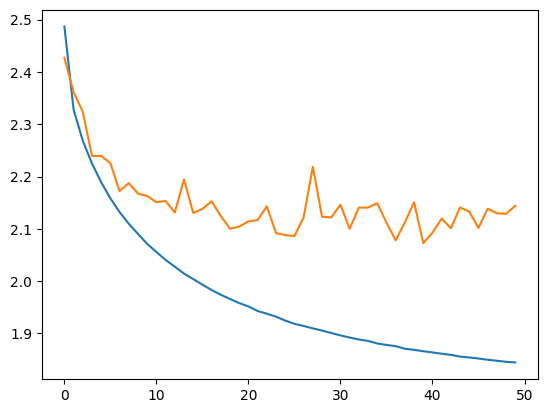

In [47]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

La diferencia entre la curva de entrenamiento y la de validación indica que el modelo presenta un ligero *overfitting*.


In [48]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
model.eval()
loss_test=0
for x,y in test_loader:
    
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.1220, grad_fn=<DivBackward0>)


La pérdida (*loss*) en el conjunto de prueba es ligeramente superior a la del conjunto de entrenamiento, lo que indica un ligero *overfitting* del modelo. Sin embargo, esto sigue siendo leve y aún hay margen para mejorar las capacidades de la red. Ahora podemos verificar la calidad de la generación de nombres.


In [49]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

LOUIS-ANDRÉ.
YOHES.
BRES.
TERIGAND.
CONKHE.


Los nombres generados son correctos, pero mejorables. Veamos si podemos obtener una menor pérdida (*loss*) en los datos de prueba utilizando el enfoque WaveNet.


## Implementación de WaveNet con PyTorch


El conjunto de datos es el mismo que en la sección anterior, por lo que no es necesario realizar ningún cambio.


### Cómo manejar la arquitectura jerárquica


Lo que queremos en nuestro modelo es procesar en paralelo grupos de *embeddings* al agrupar caracteres consecutivos. En PyTorch, si pasamos un tensor de tamaño $B \times L \times C$ a través de una capa lineal de tamaño $C \times H$, obtendremos un tensor de tamaño $B \times L \times H$, que es exactamente lo que necesitamos para implementar la red WaveNet.


Ahora, debemos encontrar cómo modificar el tamaño del tensor para realizar las operaciones de WaveNet. Nuestros 8 *embeddings* se agrupan de dos en dos y luego se procesan en paralelo. En la siguiente capa, se vuelven a agrupar de dos en dos. Por lo tanto, en cada paso, duplicamos el tamaño $H$ (o $C$) y dividimos entre dos el tamaño $L$.

Para ser más claros, en el primer paso, tenemos un tensor de tamaño $B \times 8 \times 10$ que queremos transformar en un tensor de tamaño $B \times 4 \times 20$. Esto se puede implementar con [*view()*](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) de PyTorch.


In [50]:
dummy=torch.randn([256,8,10])
# On divise par deux L et on double H/C
dummy=dummy.view(-1,dummy.shape[1]//2,dummy.shape[2]*2)
print(dummy.shape)

torch.Size([256, 4, 20])


Intentemos formalizar esto con una capa que podamos utilizar en nuestra red:


In [51]:
class FlattenConsecutive(nn.Module):
  # n est le facteur de regroupement (toujours 2 pour nous)
  def __init__(self, n):
    super(FlattenConsecutive, self).__init__()
    self.n = n   
  def __call__(self, x):
    # On récupère les dimensions de l'entrée
    B, T, C = x.shape 
    # On fait la transformation x2 et /2
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: 
      x = x.squeeze(1) # Si le tensor a une dimension qui vaut 1, on la supprime
    self.out = x
    return self.out

### Creación del modelo


Es hora de crear nuestro modelo. Para mayor simplicidad, utilizamos [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) para agrupar nuestras capas.


In [52]:
class wavenet(nn.Module):
  def __init__(self,embed_dim=10,hidden_dim=128, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    
    self.net=nn.Sequential(nn.Embedding(46,embed_dim),
      # B*8*10
      FlattenConsecutive(2), nn.Linear(embed_dim*2,hidden_dim),nn.Tanh(),
      # B*4*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*2*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*hidden_dim
      nn.Linear(hidden_dim,46)
    )   
        
  def forward(self,x):
    logits=self.net(x)
    return logits


Inicializamos nuestro modelo y los hiperparámetros.


In [53]:
model=wavenet()
epochs=40
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

Y comenzamos el entrenamiento.


In [54]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Mise à jour des poids du modèle
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")
  

Epoch 0 - Training loss: 2.541, Validation loss: 2.459
Epoch 10 - Training loss: 2.013, Validation loss: 2.094
Epoch 20 - Training loss: 1.898, Validation loss: 2.096
Epoch 30 - Training loss: 1.834, Validation loss: 2.060


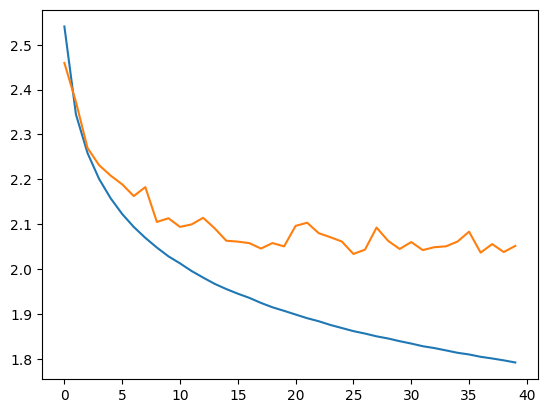

In [55]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

In [56]:
model.eval()
loss_test=0
for x,y in test_loader:
      
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.0132, grad_fn=<DivBackward0>)


Obtenemos una pérdida (*loss*) muy aceptable y menor que la del modelo completamente conectado con un contexto de 8.

**Notas**: Al observar la curva de validación en comparación con la curva de entrenamiento, nos damos cuenta de que podría haber un problema (lo mismo ocurre con el modelo completamente conectado de contexto 8). Depende de ustedes ver si logran corregir este problema con lo que han aprendido en los cursos anteriores (consultar [curso sobre redes completamente conectadas](../02_RéseauFullyConnected/README.md)).


In [68]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

MARICE.
JEXE.
RAYEDE.
CHAHI.
RISHAE.


¡La generación de nombres mejora cada vez más!


**Ejercicio**: Para practicar, intente modificar los parámetros de entrenamiento, la arquitectura de la red y otros aspectos para lograr una pérdida (*loss*) inferior a 2.0 en los datos de prueba. Punto extra si reduce el número de parámetros del modelo.
